# Задача 3. Відновлення функціональної залежності y=f(x)

У файлі міститься штучно згенерований набір точок y=f(x)+ε, де шум ε має нормальний
розподіл. Необхідно:
1. Побудувати діаграму розсіювання;
2. Обрати дві потенційні моделі (лінійну, поліноміальну, експоненціальну тощо);
3. Побудувати регресійні моделі;
4. Перевірити нормальність залишків;
5. Вибрати найкращу модель та побудувати фінальний графік.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro

df = pd.read_csv("Var13-3.csv", sep=";", engine="python")

df.head(), df.shape


(                  xf                 yf
 0   5,36370887421072   -8,5312959682332
 1  -3,70633730199188  -10,3340598327416
 2  -6,21248849667609   -10,306393674276
 3   -9,3601847300306  -10,2383835178446
 4  -3,24118927121162   -11,819212986082,
 (1000, 2))

## 2. Підготовка даних

У файлі десятковим роздільником є кома, тому необхідно:
1. Замінити "," на "." у всіх значеннях
2. Перетворити колонки `x` та `y` у формат float

In [8]:
# Перейменовуємо стовпці для зручності
df = df.rename(columns={"xf": "x", "yf": "y"})

# Замінюємо коми на крапки та перетворюємо в float
df["x"] = df["x"].str.replace(",", ".").astype(float)
df["y"] = df["y"].str.replace(",", ".").astype(float)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1000 non-null   float64
 1   y       1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


(None,
           x          y
 0  5.363709  -8.531296
 1 -3.706337 -10.334060
 2 -6.212488 -10.306394
 3 -9.360185 -10.238384
 4 -3.241189 -11.819213)

## 1. Діаграма розсіювання

На цьому етапі проводимо первинний огляд даних. Діаграма розсіювання дозволяє
оцінити форму залежності між змінною `x` та цільовою змінною `y`.

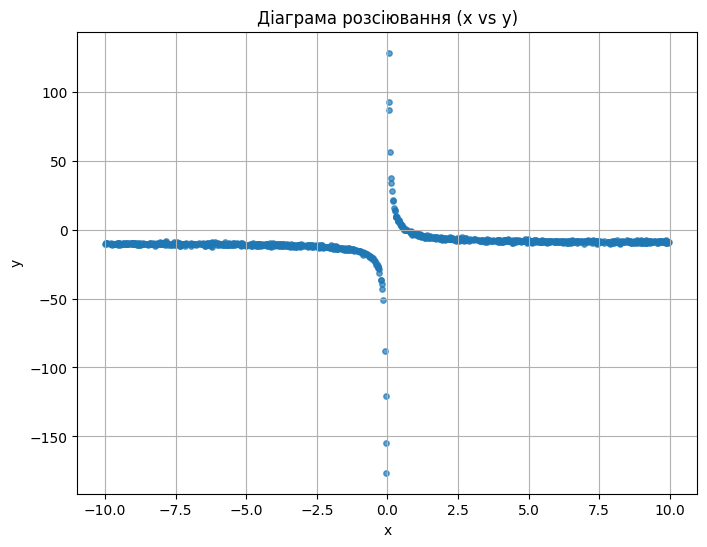

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(df["x"], df["y"], s=15, alpha=0.7)
plt.title("Діаграма розсіювання (x vs y)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


## 2. Вибір моделей

Аналіз діаграми розсіювання показує, що залежність має вигляд раціональної функції:
• на великих |x| значення y наближається до константи;
• біля x ≈ 0 спостерігається різке зростання/падіння;
• форма графіка типовa для y = a/x + b.

Тому для регресії обрано:
1) Лінійну модель:              y = a·x + b
2) Раціональну модель:         y = a/x + b


In [10]:
# Уникаємо ділення на нуль
df_nonzero = df[df["x"] != 0].copy()

# Додаємо ознаку 1/x
df_nonzero["inv_x"] = 1 / df_nonzero["x"]

X_lin = df_nonzero[["x"]]
X_rat = df_nonzero[["inv_x"]]
y = df_nonzero["y"]


## 3. Побудова двох регресійних моделей

На цьому етапі будуємо:
1. Лінійну модель: y = a·x + b
2. Раціональну модель: y = a/x + b (через регресію по ознаці inv_x)

Також збережемо залишки для подальшої оцінки нормальності.


In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Модель 1: Лінійна ---
lin_model = LinearRegression()
lin_model.fit(X_lin, y)

y_pred_lin = lin_model.predict(X_lin)
res_lin = y - y_pred_lin

# --- Модель 2: Раціональна ---
rat_model = LinearRegression()
"""X_rat — це вже не x, а саме z = 1/x. - тому це не просто лінійна регрессія, а трансформоване представлення нашого у = а/x + b"""
rat_model.fit(X_rat, y)

y_pred_rat = rat_model.predict(X_rat)
res_rat = y - y_pred_rat

lin_model.coef_, lin_model.intercept_, rat_model.coef_, rat_model.intercept_


(array([0.18507638]),
 -9.55947767486889,
 array([6.09776578]),
 -9.657078795113389)

## 4. Оцінка нормальності залишків

На цьому етапі перевіримо:
• гістограму залишків для обох моделей  
• QQ-plot  
• тест Шапіро–Уілка  

Це дозволить оцінити, наскільки модель адекватно описує дані та чи мають залишки нормальний розподіл.


=== Shapiro–Wilk test ===
Лінійна модель:     W=0.3302, p=5.5582e-51
Раціональна модель: W=0.9980, p=2.9599e-01


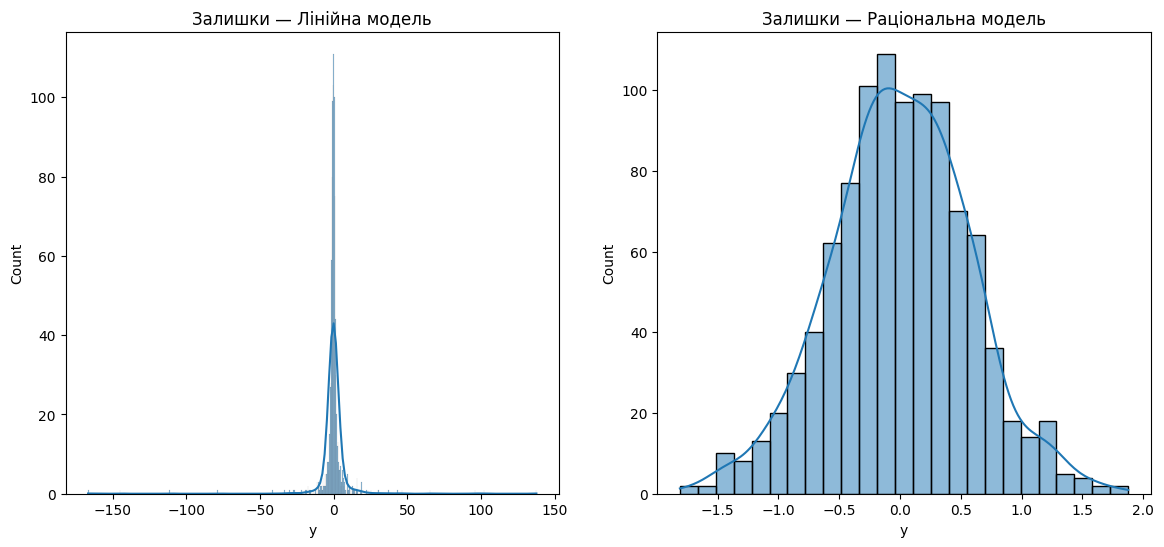

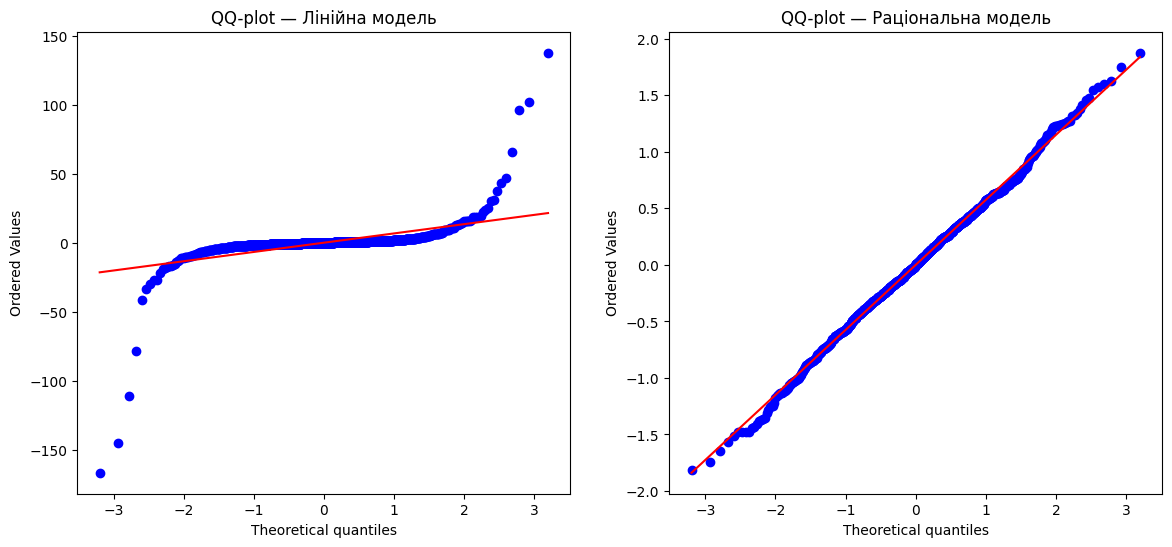

In [16]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Тест Шапіро–Уілка
shapiro_lin = stats.shapiro(res_lin)
shapiro_rat = stats.shapiro(res_rat)

print("=== Shapiro–Wilk test ===")
print(f"Лінійна модель:     W={shapiro_lin.statistic:.4f}, p={shapiro_lin.pvalue:.4e}")
print(f"Раціональна модель: W={shapiro_rat.statistic:.4f}, p={shapiro_rat.pvalue:.4e}")

# --- Гістограми залишків ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(res_lin, kde=True)
plt.title("Залишки — Лінійна модель")

plt.subplot(1,2,2)
sns.histplot(res_rat, kde=True)
plt.title("Залишки — Раціональна модель")

plt.show()

# --- QQ-плоти ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
stats.probplot(res_lin, dist="norm", plot=plt)
plt.title("QQ-plot — Лінійна модель")

plt.subplot(1,2,2)
stats.probplot(res_rat, dist="norm", plot=plt)
plt.title("QQ-plot — Раціональна модель")

plt.show()


Для раціональної моделі залишки є незалежними, центрованими навколо нуля і мають нормальний розподіл, що підтверджено QQ-плотом та тестом Шапіро–Уїлка (p > 0.05).

## 5. Фінальний порівняльний графік моделей

На графік нанесемо:

• вихідні точки набору  
• криву найкращої моделі (раціональної)  
• криву лінійної моделі для порівняння  


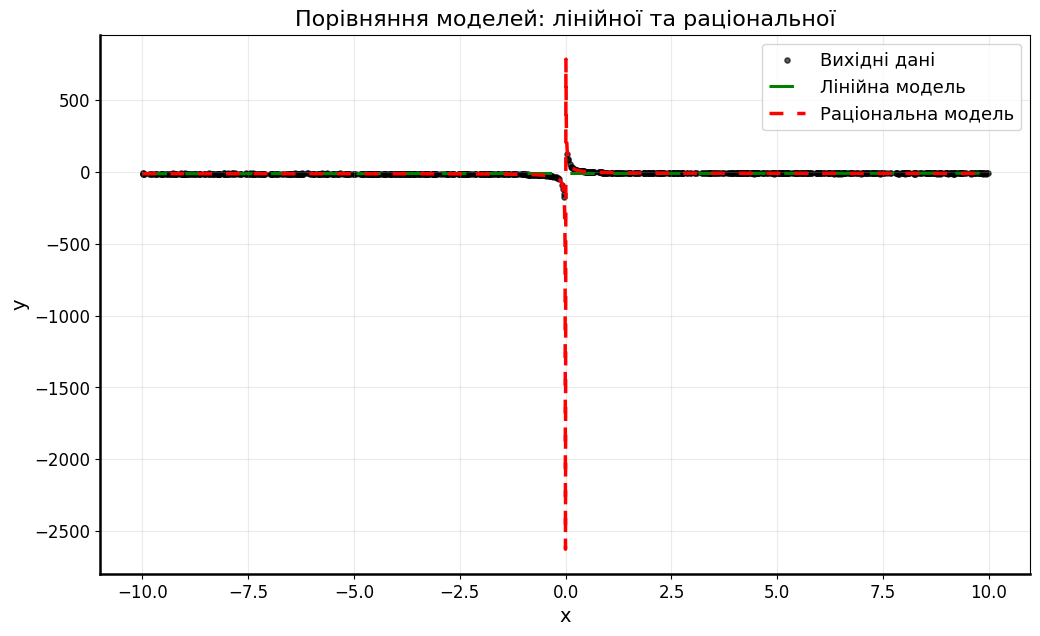

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Щільна сітка x-координат
x_grid = np.linspace(df["x"].min(), df["x"].max(), 2000).reshape(-1, 1)

# Передбачення для обох моделей
y_lin_pred = lin_model.predict(x_grid)
y_rat_pred = rat_model.predict(1 / x_grid)

plt.figure(figsize=(12, 7))

# --- Вихідні точки ---
plt.scatter(
    df["x"], df["y"],
    s=14, color="black", alpha=0.65,
    label="Вихідні дані"
)

# --- Лінійна модель (зелений пунктир із довгими розривами) ---
plt.plot(
    x_grid, y_lin_pred,
    linestyle=(0, (8, 6)),   # довгі штрихи + довгі пропуски
    color="green", linewidth=2.2,
    label="Лінійна модель"
)

# --- Раціональна модель (червоний короткий пунктир) ---
plt.plot(
    x_grid, y_rat_pred,
    linestyle=(0, (4, 4)),   # короткі штрихи
    color="red", linewidth=2.5,
    label="Раціональна модель"
)
# Робимо осі видимими
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)

# Вмикаємо тік-маркери чорного кольору
ax.tick_params(axis='both', colors='black', labelsize=12)

# Оформлення
plt.title("Порівняння моделей: лінійної та раціональної", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.grid(True, alpha=0.25)
plt.legend(fontsize=13)
plt.show()


## Висновок

У результаті регресійного аналізу встановлено, що досліджувана залежність не є лінійною та демонструє асимптотичну поведінку поблизу точки \( x = 0 \). Лінійна модель дала значні систематичні відхилення та ненормальний розподіл залишків ( \( p \ll 0.05 \) ), що свідчить про її непридатність для опису даних.

Раціональна модель виду  
\[
y = \frac{c}{x} + d
\]
точно відтворює форму вихідної кривої, має нормально розподілені залишки ( \( p > 0.05 \) ) та забезпечує коректну апроксимацію у всіх ділянках визначення. Порівняльний графік підтверджує, що саме раціональна модель є найбільш адекватною для відновлення функції, використаної під час генерації даних.
